# load model

In [14]:
from model import Model 
from pathlib import Path
import torch
from DataLoader import TRANSFORM_STRUCTURE_VAL, TRANSFORM_IMAGE
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image 
import numpy as np
model_name = "model_final_a2ht8h2w"
PATH = Path(f"model/{model_name}.pth")

IMAGE_SIZE = (512, 1024)
BATCH_SIZE = 10
def preprocess(image):
    image = TRANSFORM_STRUCTURE_VAL(image,IMAGE_SIZE)
    image = TRANSFORM_IMAGE(image)
    return image


In [15]:
model = Model()
model.load_state_dict(torch.load(PATH))
model.to("cuda")

Model(
  (e1): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (e2): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2), st

In [16]:
from DataLoader import *
from utils import LABELS, map_id_to_train_id, train_id_to_name, remove_classes_from_tensor
from DataVisualizations import visualize_criterion
from train_utils import _init_wandb, _print_quda_info, load_model_weights, log_dice_loss, ModelEvaluator, save_model

In [17]:
# cittysckapes unseen data
from dataclasses import dataclass

@dataclass
class Fake_args():
    figure_size: int = 9
    data_path: str = './data'
    batch_size: int = BATCH_SIZE
    workers = 4 
args = Fake_args()
_ , val_loader = generate_data_loaders(args)

In [18]:
IMAGE_SET_SIZE = len(val_loader) * BATCH_SIZE

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


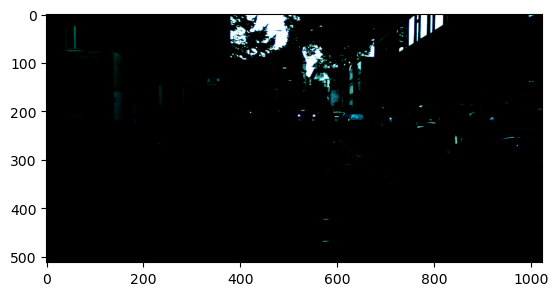

In [30]:
for i, (data,target) in enumerate(val_loader):
    plt.imshow(data[0].squeeze(0).permute(1,2,0))
    break

## Load different datasets

In [19]:

class RandomNoiseDataset(Dataset):
    def __init__(self, num_images, image_size=(512, 1024)):
        self.num_images = num_images
        self.image_size = image_size

    def __len__(self):
        return self.num_images

    def __getitem__(self, idx) -> Image:
        random_data = np.random.randint(0, 256, (*self.image_size, 3), dtype=np.uint8)
        im = Image.fromarray(random_data)
        im = preprocess(im)
        return im , [0]

random_noise_dataloader_dataset = RandomNoiseDataset(IMAGE_SET_SIZE, IMAGE_SIZE)
random_noise_dataloader = DataLoader(random_noise_dataloader_dataset, batch_size=BATCH_SIZE, shuffle=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


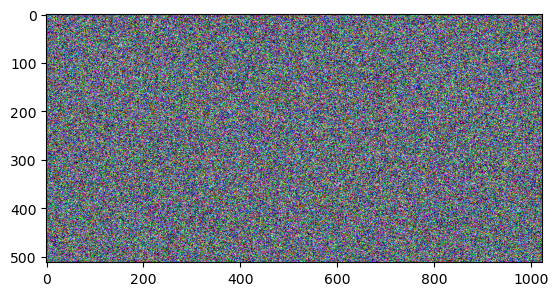

In [20]:
for i, (data,_) in enumerate(random_noise_dataloader):
    
    plt.imshow(data[0].squeeze(0).permute(1,2,0))
    break

In [21]:

class RandomConstantDataset(Dataset):
    def __init__(self, num_images, image_size=(512, 1024)):
        self.num_images = num_images
        self.image_size = image_size

    def __len__(self):
        return self.num_images

    def __getitem__(self, idx) -> Image:
        color = np.random.randint(0, 256, size=3)  # Choose a random color
        image_data = np.full((*self.image_size, 3), color, dtype=np.uint8)
        im = Image.fromarray(image_data)
        im = preprocess(im)
        return im , [0] 

constant_image_dataset = RandomConstantDataset(IMAGE_SET_SIZE,IMAGE_SIZE)
constant_image_dataloader = DataLoader(constant_image_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [22]:
# cifar 100 image
from torchvision import datasets, transforms
from torch.utils.data import Subset
path = Path("C:/Users/20193696/Desktop/Y5Q3/DeepLearning/data")

cifar_100_dataset = datasets.CIFAR100(root=path, train=True, download=True, transform=preprocess)
# Create a new dataset that only includes the first 100 images
subset_cifar_100_dataset = Subset(cifar_100_dataset, indices=range(IMAGE_SET_SIZE))
# Create a dataloader for the subset
cifar_100_dataloader = torch.utils.data.DataLoader(subset_cifar_100_dataset, batch_size=BATCH_SIZE, shuffle=True)



Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


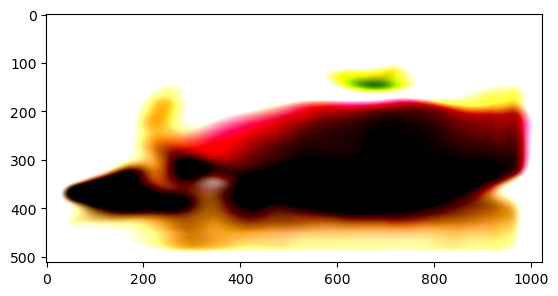

In [23]:
for i, (data,_) in enumerate(cifar_100_dataloader):
    plt.imshow(data[0].squeeze(0).permute(1,2,0))
    break

# predict on generated data

In [27]:
# general function that makes predictions based on a dataloader and returns the mean activation: 
def predict_on_data_loader(dataloader):
    mean_activations = []
    for i, (data, _ ) in enumerate(dataloader):
        with torch.no_grad():
            data = data.squeeze(1)
            data = data.to('cuda')
            output = model(data)
            print(output.shape)
            softmax_score_per_pixel, _ = torch.max(output.permute(0,2,3,1), dim=3)
            mean_softmax_score_per_image = torch.mean(softmax_score_per_pixel,dim=(1,2))
            mean_activations.extend(mean_softmax_score_per_image.tolist())

    return mean_activations

In [28]:
data_loaders = {"RandomConstantDataset": constant_image_dataloader,
                "RandomNoiseDataset": random_noise_dataloader,
                "Cifar100": cifar_100_dataloader,
                "Cityscapes": val_loader}

In [29]:
dataset_mean_activations = {}
model.eval()
for key, dataloader in data_loaders.items():
    mean_activation = predict_on_data_loader(dataloader)
    dataset_mean_activations[key] = mean_activation
    print(f"Mean activation for {key}: {np.mean(mean_activation)}")

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.25 GiB. GPU 0 has a total capacty of 4.00 GiB of which 0 bytes is free. Of the allocated memory 9.34 GiB is allocated by PyTorch, and 76.76 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## visualize 2d max activation

In [33]:
import seaborn as sns
def plot_mean_activations(mean_activations):
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    for distr_name, distr in mean_activations.items():
        sns.histplot(distr, bins=100, ax=ax, label=distr_name, kde=True)
    
    ax.set_title('Distribution of Image MSF per dataset')
    ax.set_xlabel('Activation Value')
    ax.set_ylabel('Frequency')
    plt.legend()
    plt.show()
    plt.savefig("mean_activations.png")


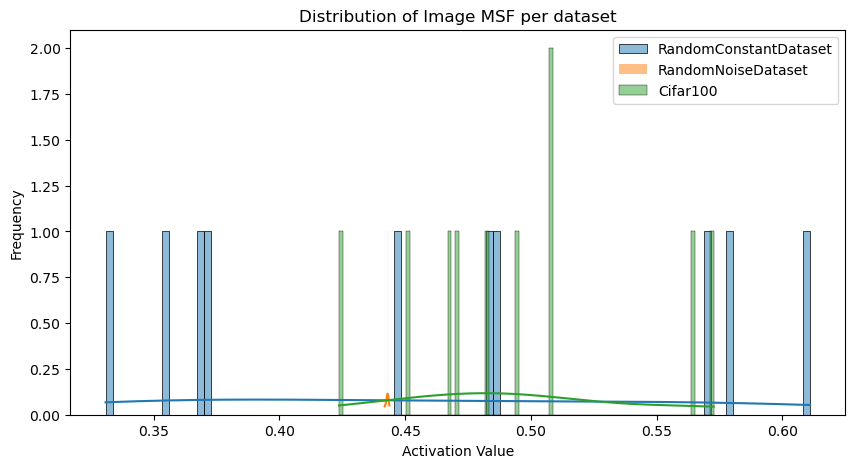

<Figure size 640x480 with 0 Axes>

In [34]:
plot_mean_activations(dataset_mean_activations)

#Calculate ROC and plot it

In [48]:
from sklearn.metrics import roc_curve, auc
# for each dataset, calculate the Roc wheaterh activation is above a threshold
def calculate_roc(mean_activations):
    plt.figure()
    id_images_MSF = np.random.uniform(0.4,0.65,10) #mean_activations['mean_activations']
    IID_target = np.ones(len(id_images_MSF))
    
    for distr_name, distr in mean_activations.items():
        if distr_name == 'Cityscapes':
            pass
        else:
            OOD_target = np.zeros(len(distr))
            
        total_MSF = np.concatenate((id_images_MSF, distr))
        total_target = np.concatenate((IID_target, OOD_target))
        
        fpr, tpr, _ = roc_curve(total_target, total_MSF)
        print(fpr, tpr)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, label=f'{distr_name} (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig("roc.png")
    plt.show()

[0.  0.  0.1 0.1 0.3 0.3 0.5 0.5 0.6 0.6 1. ] [0.  0.1 0.1 0.3 0.3 0.7 0.7 0.9 0.9 1.  1. ]
[0. 0. 0. 1. 1.] [0.  0.1 0.9 0.9 1. ]
[0.  0.  0.  0.2 0.2 0.4 0.4 0.7 0.7 0.8 0.8 0.9 0.9 1. ] [0.  0.1 0.3 0.3 0.6 0.6 0.7 0.7 0.8 0.8 0.9 0.9 1.  1. ]


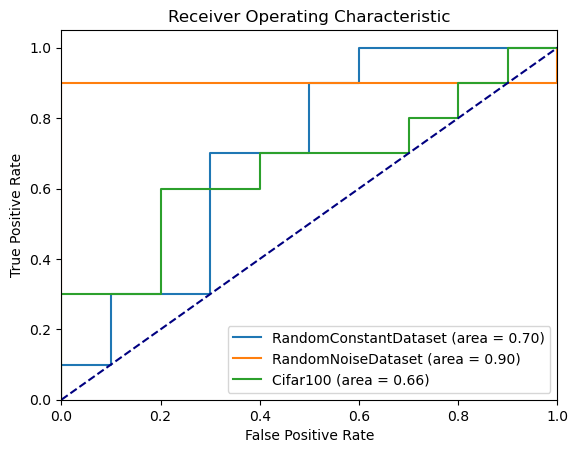

In [49]:
calculate_roc(dataset_mean_activations)

## Visualize 3d simmelarity